<a href="https://colab.research.google.com/github/SiracencoSerghei/DataScienceHW/blob/main/HW4/hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [2]:
url = 'https://drive.google.com/uc?id=1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96'
df = pd.read_csv(url)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

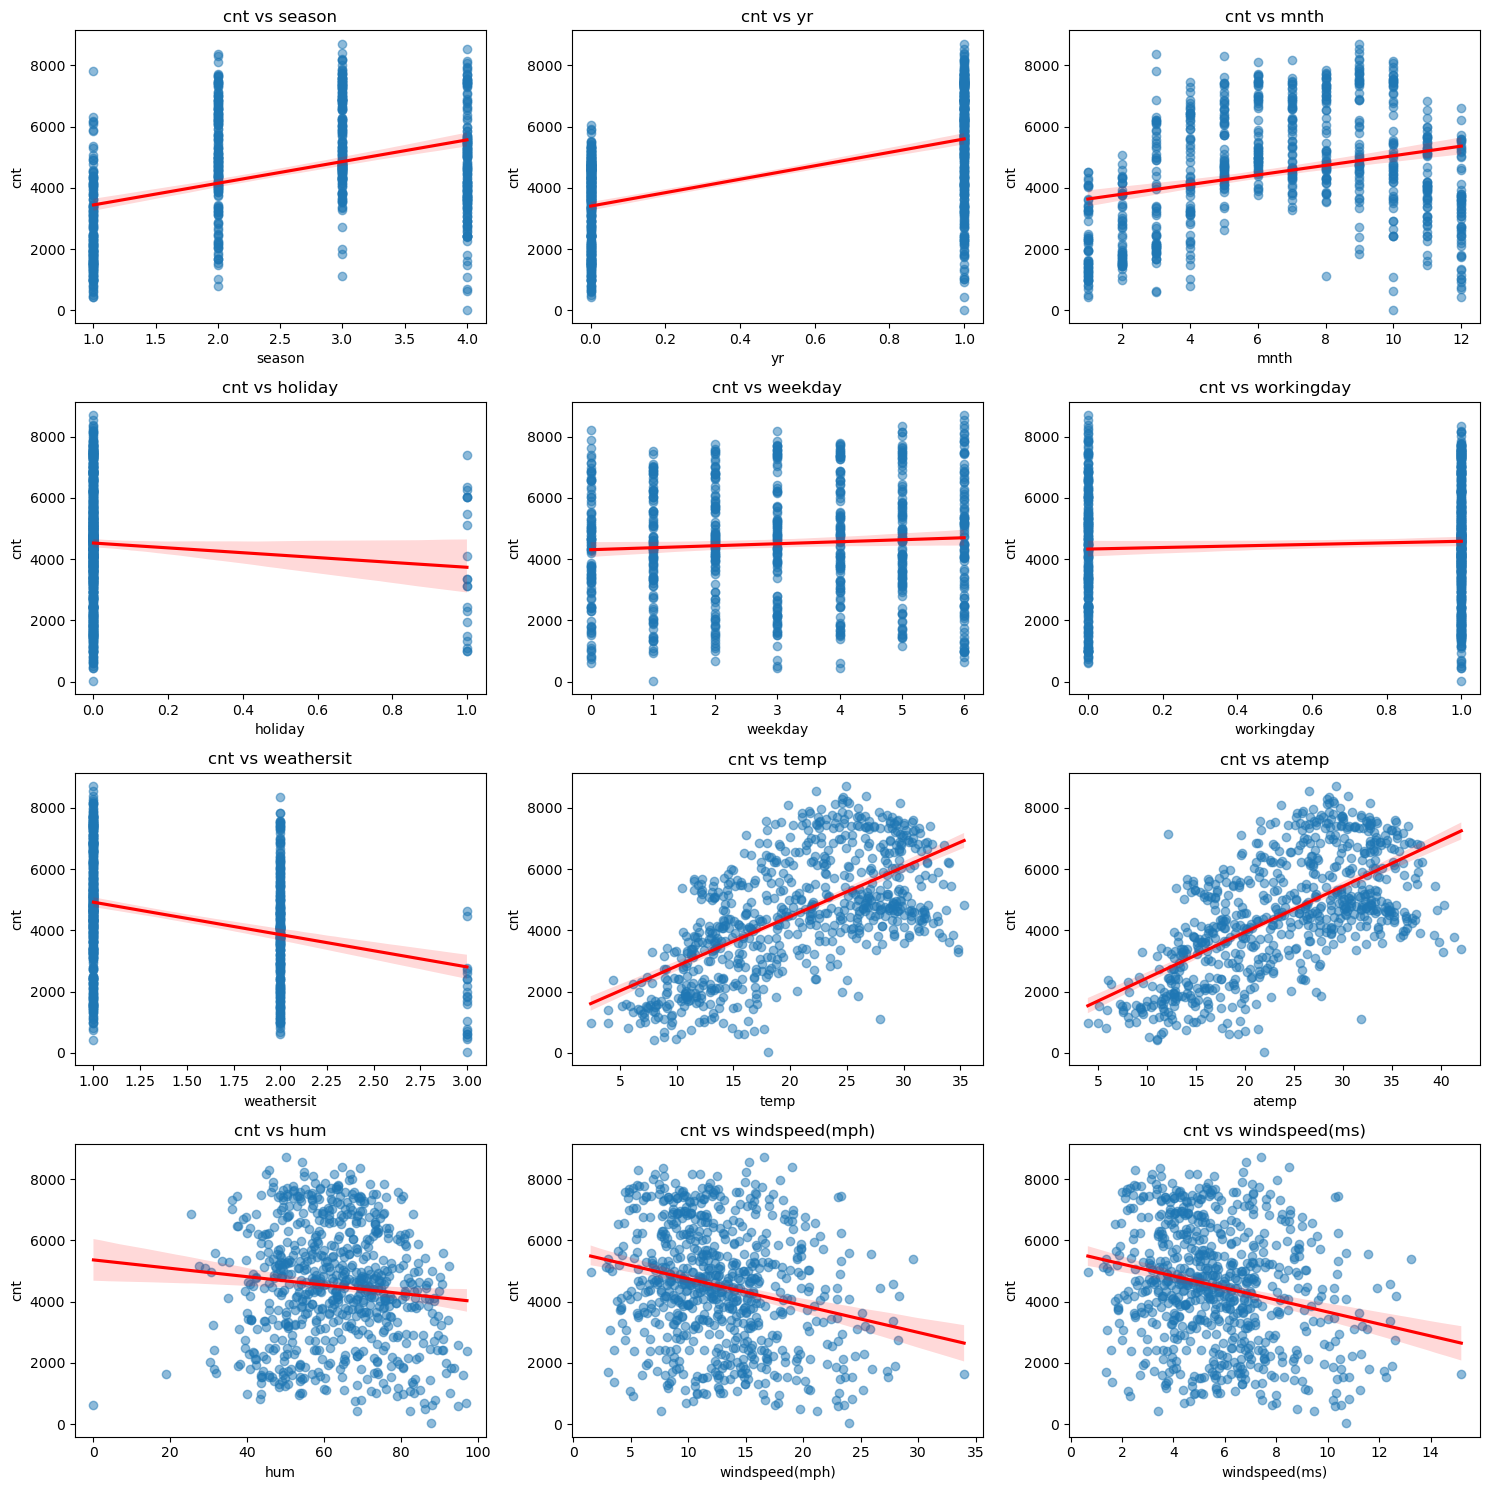

In [3]:
# Put you code here

# List of attributes to plot against `cnt`
attributes = df.columns[:-1]

# Create 12 subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15)) # Створюємо сітку з 4 рядків і 3 стовпців для підграфіків (загалом 12 підграфіків)
# Якщо не виконати перетворення, доведеться звертатися до підграфіків у двовимірному масиві, наприклад, через axes[0, 0], axes[0, 1] тощо, що менш зручно для автоматизації через цикл.
axes = axes.flatten()

# Generate plots
for i, attr in enumerate(attributes):
    # sns.scatterplot(data=df, x=attr, y="cnt", ax=axes[i])
    sns.regplot(data=df, x=attr, y="cnt", ax=axes[i], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
    # sns.lineplot(data=df, x=attr, y="cnt", ax=axes[i], color="blue", linewidth=2)
    axes[i].set_title(f"cnt vs {attr}")
    axes[i].set_xlabel(attr)
    axes[i].set_ylabel("cnt")

# Adjust layout
plt.tight_layout()  # для автоматичного налаштування відступів між підграфіками
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

Відповіді:

1. Існує пряма залежність кількості прокатів від місяця. Починаючи з січня кількість прокатів поступово збільшується до вереесня (максимальна точка) і потім поступово спадає до грудня. У теплі місяці, особливо влітку, кількість прокатів зазвичай збільшується через сприятливі погодні умови та більше активностей на свіжому повітрі. В холодні місяці, особливо взимку, кількість прокатів зменшується через знижені температури та можливі несприятливі погодні умови.
2. Температура (temp) та температура за відчуттями (atemp). Вологість (hum) також впливає на кількість прокатів.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
weathersit        0.297391
mnth              0.279977
windspeed(ms)     0.234545
windspeed(mph)    0.234545
hum               0.100659
holiday           0.068348
weekday           0.067443
workingday        0.061156
dtype: float64


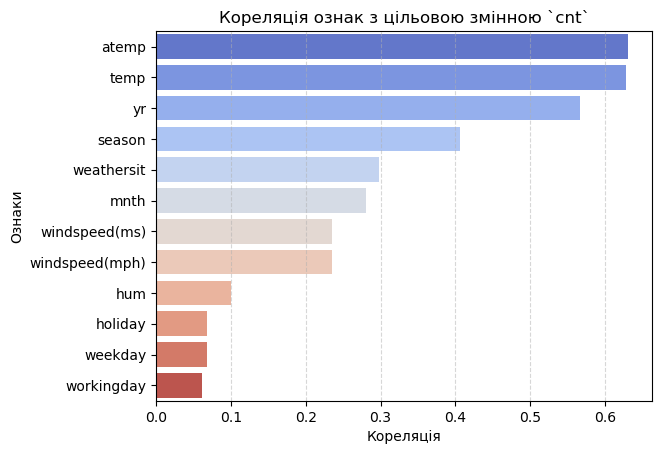

In [4]:
# Put your code here

# Рахуємо кореляції всіх ознак, окрім останньої, з останньою за допомогою методу corrwith
correlations = df.iloc[:, :-1].corrwith(df.iloc[:, -1])
correlations = df.iloc[:, :-1].corrwith(df["cnt"])

# Відсортуємо за абсолютним значенням кореляції, щоб побачити найсильніші залежності
correlations = correlations.abs().sort_values(ascending=False)

print(correlations)

# Візуалізація
sns.barplot(x=correlations.values, y=correlations.index, hue=correlations.index, palette="coolwarm", legend=False)

plt.xlabel("Кореляція")
plt.ylabel("Ознаки")
plt.title("Кореляція ознак з цільовою змінною `cnt`")
plt.grid(axis="x", linestyle="--", alpha=0.5)

plt.show()

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

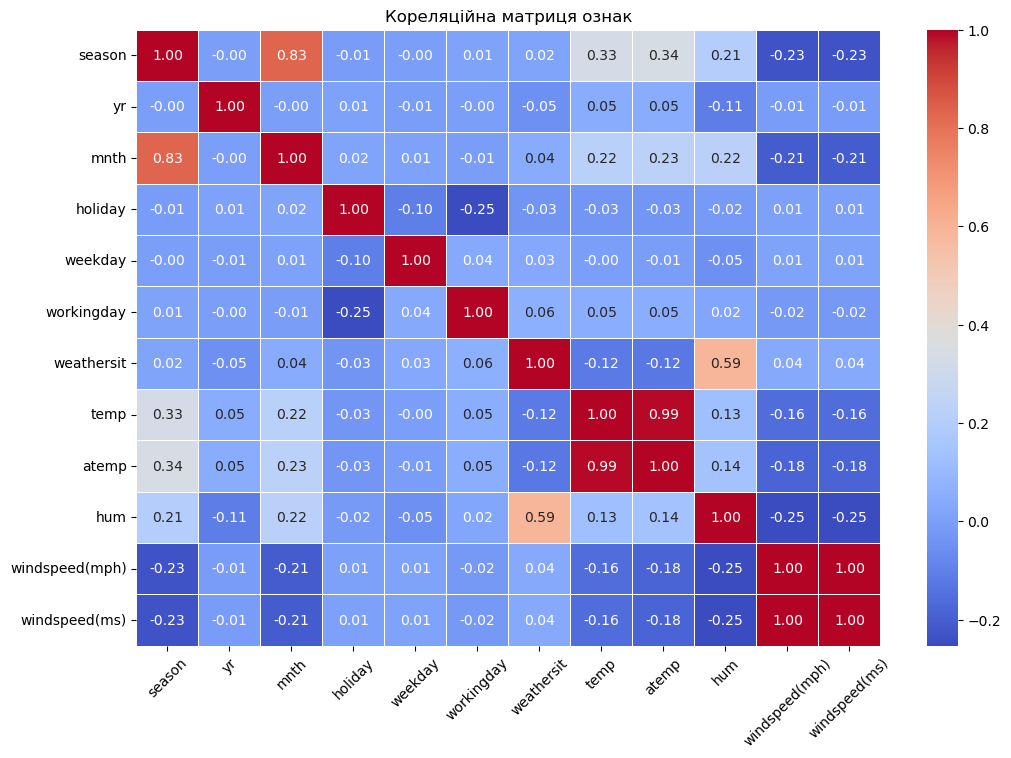

In [5]:
# Обчислення матриці кореляцій
corr_matrix = df.iloc[:, :-1].corr()

# Візуалізація кореляційної матриці
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.xticks(rotation=45)
plt.title("Кореляційна матриця ознак")
plt.show()

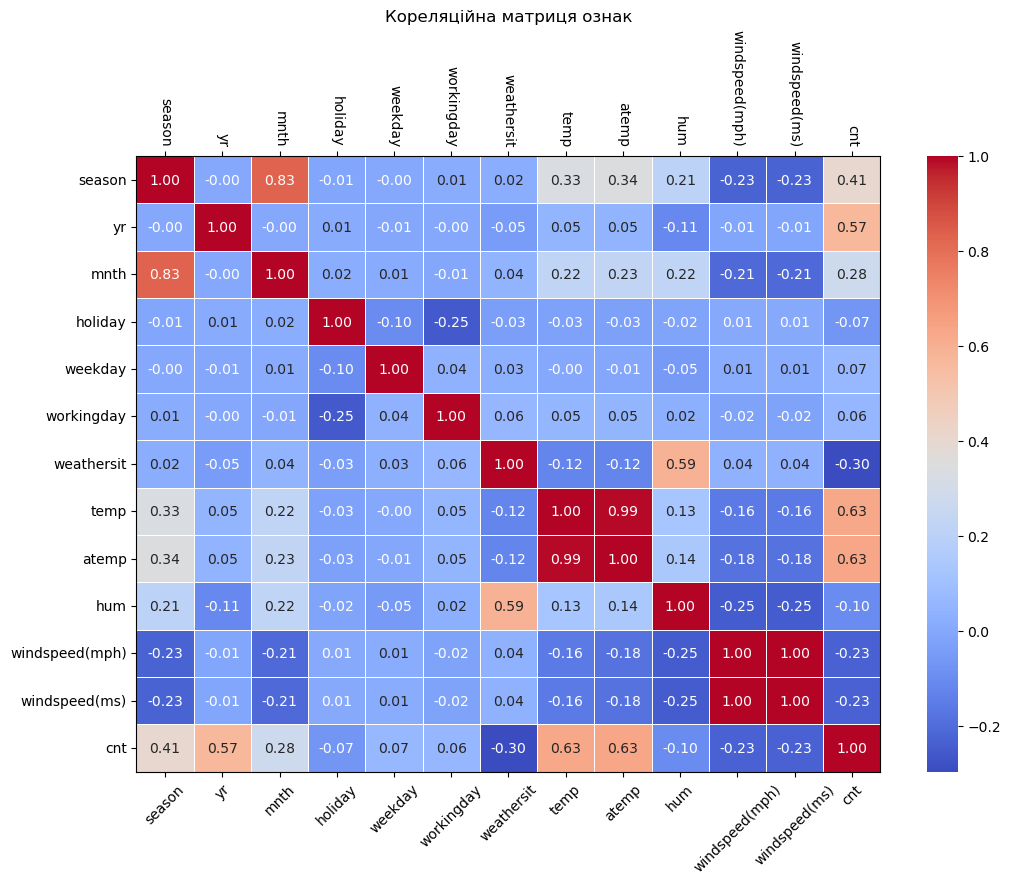

In [6]:
# Обчислення матриці кореляцій
corr_matrix = df.corr()

# Візуалізація кореляційної матриці
plt.figure(figsize=(12, 8))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Налаштування міток осі X (знизу)
plt.xticks(rotation=45)

# Додавання дубльованої осі X зверху
ax_top = ax.figure.axes[0].twiny()  # Використовуємо ту ж фігуру для створення верхньої осі
ax_top.set_xlim(ax.get_xlim())  # Синхронізуємо шкалу осей
ax_top.set_xticks(ax.get_xticks())
ax_top.set_xticklabels(ax.get_xticklabels(), rotation=-90)
ax_top.xaxis.set_label_position('top')
ax_top.xaxis.tick_top()

# Додавання заголовка
plt.title("Кореляційна матриця ознак")

plt.show()

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [7]:
# Put your code here

selected_columns = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]

# Обчислення кореляційної матриці тільки для вибраних ознак
corr_matrix = df[selected_columns].corr()

corr_matrix


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

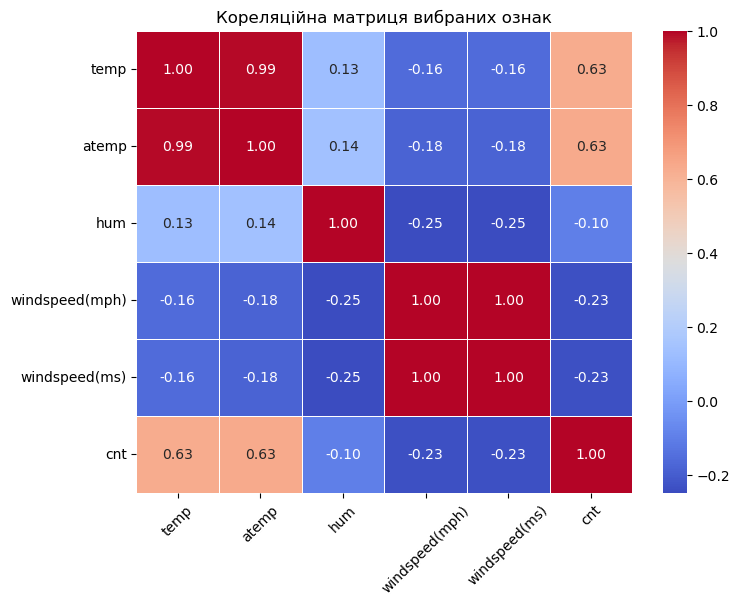

In [8]:

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Кореляційна матриця вибраних ознак")
plt.xticks(rotation=45)
plt.show()

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [9]:
# Put your code here

mean_values = df.mean()
mean_values

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [10]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [11]:
SEED = 42
df_shuffled = shuffle(df, random_state=SEED)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [12]:
X.shape, y.shape

((731, 12), (731,))

In [13]:
print(f"{X.max()=}")
print(f"{X.min()=}")
print(f"{X[0].max()=}")
print(f"{X[0].min()=}")
print(f"{y.max()=}")
print(f"{y.min()=}")

X.max()=np.float64(5.814595756329395)
X.min()=np.float64(-4.411486147280981)
X[0].max()=np.float64(1.5886601861579452)
X[0].min()=np.float64(-0.7260481545646825)
y.max()=8714
y.min()=22


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [14]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [15]:
# Put your code here

linear_regression = LinearRegression()
linear_regression.fit(X, y)
linear_weights = linear_regression.coef_
linear_bias = linear_regression.intercept_

for feature, weight in zip(df.columns, linear_weights):
    print(f"\033[1m{feature}\033[0m: {weight}")

print()
print(f"\033[1mBias\033[0m: {linear_bias}")

season: 570.8683682349464
yr: 1021.9655165928652
mnth: -141.30480132476436
holiday: -86.75977350260133
weekday: 137.22429786240198
workingday: 56.391510481686474
weathersit: -330.2285514523417
temp: 367.4696244443872
atemp: 585.5608798848713
hum: -145.61062773283885
windspeed(mph): 12459233387995.324
windspeed(ms): -12459233388193.781

Bias: 4504.3545291714845


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

# Мультиколінеарність та її вплив на лінійну регресію

Лінійна регресія може мати проблеми з мультиколінеарністю, коли ознаки є лінійно залежними або дуже сильно корельованими між собою. Ось як це можна пояснити та доповнити кодом:

## Мультиколінеарність та її вплив на регресію

Коли в матриці ознак \( X \) є лінійно залежні стовпці (ознаки), матриця \( X^T X \) (трансформована матриця ознак, помножена на саму себе) стає виродженою, що означає, що її визначник наближається до нуля. Це робить неможливим обчислення оберненої матриці для подальшого розв'язку рівняння для ваг лінійної моделі:

$$
w = (X^T X)^{-1} X^T y
$$

Коли ознаки сильно корелюють одна з одною, це створює нестабільність у розв'язках для коефіцієнтів, які можуть стати дуже великими, що призводить до того, що модель стає перенавченою і не може правильно узагальнювати нові дані. Це називається проблемою мультиколінеарності.

## Як вирішити проблему мультиколінеарності

Для того, щоб запобігти цій проблемі, можна застосувати регуляризацію. Регуляризація додає штраф за великі значення коефіцієнтів до функції втрат моделі, тим самим обмежуючи величину коефіцієнтів і знижуючи можливу нестабільність моделі.

### Lasso регресія (L1 регуляризація)

У цьому випадку до функції втрат додається L1-норма ваг:

$$
J(w) = \text{MSE}(w) + \alpha \sum_{i=1}^{n} |w_i|
$$

де \($\alpha$\) — це коефіцієнт регуляризації, який контролює вплив регуляризації на модель. Lasso може "сигналізувати" деякі коефіцієнти в нуль, що може бути корисно для відбору ознак.

### Ridge регресія (L2 регуляризація)

Для Ridge регуляризації додається L2-норма ваг:

$$
J(w) = \text{MSE}(w) + \alpha \sum_{i=1}^{n} w_i^2
$$

L2 регуляризація не призводить до обнулення коефіцієнтів, але вона обмежує їх величину, що дозволяє зменшити вплив мультиколінеарності.


---
### Завдання 6
---
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [16]:
# Put your code here

from sklearn import linear_model

lasso_regressor = linear_model.Lasso()
lasso_regressor.fit(X, y)
lasso_weights = lasso_regressor.coef_
lasso_bias = lasso_regressor.intercept_

for feature, weight in zip(df.columns, lasso_weights):
    print(f"\033[1m{feature}\033[0m: {weight}")

print()
print(f"\033[1mBias\033[0m: {lasso_bias}")


season: 560.2416160308862
yr: 1019.4634940657195
mnth: -128.73062703678715
holiday: -86.15278133371106
weekday: 137.34789390496323
workingday: 55.21237064135662
weathersit: -332.3698569623487
temp: 376.36323620969586
atemp: 576.5307935045538
hum: -144.12915500348592
windspeed(mph): -197.13968940248492
windspeed(ms): -2.8050769963390902e-08

Bias: 4504.3488372093025


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [17]:
# Put your code here

ridge_regressor = linear_model.Ridge()
ridge_regressor.fit(X, y)
ridge_weights = ridge_regressor.coef_
ridge_bias = ridge_regressor.intercept_

for feature, weight in zip(df.columns, ridge_weights):
    print(f"\033[1m{feature}\033[0m: {weight}")

print()
ridge_bias

season: 563.0645722520198
yr: 1018.9483787875305
mnth: -131.8733202824793
holiday: -86.74609799709206
weekday: 138.005111178719
workingday: 55.903110375064756
weathersit: -332.3497884990733
temp: 386.457889191948
atemp: 566.3470470600261
hum: -145.07132729867166
windspeed(mph): -99.25944108188017
windspeed(ms): -99.25944115425338



np.float64(4504.3488372093025)

In [18]:
df_weights = pd.DataFrame({
    'Feature': df.columns[:-1],  # ознаки
    'Linear Regression': linear_weights,  # ваги лінійної регресії
    'Ridge Regression': ridge_weights,  # ваги Ridge
    'Lasso Regression': lasso_weights  # ваги Lasso
})

# Показуємо результат
print(df_weights)

           Feature  Linear Regression  Ridge Regression  Lasso Regression
0           season       5.708684e+02        563.064572      5.602416e+02
1               yr       1.021966e+03       1018.948379      1.019463e+03
2             mnth      -1.413048e+02       -131.873320     -1.287306e+02
3          holiday      -8.675977e+01        -86.746098     -8.615278e+01
4          weekday       1.372243e+02        138.005111      1.373479e+02
5       workingday       5.639151e+01         55.903110      5.521237e+01
6       weathersit      -3.302286e+02       -332.349788     -3.323699e+02
7             temp       3.674696e+02        386.457889      3.763632e+02
8            atemp       5.855609e+02        566.347047      5.765308e+02
9              hum      -1.456106e+02       -145.071327     -1.441292e+02
10  windspeed(mph)       1.245923e+13        -99.259441     -1.971397e+02
11   windspeed(ms)      -1.245923e+13        -99.259441     -2.805077e-08


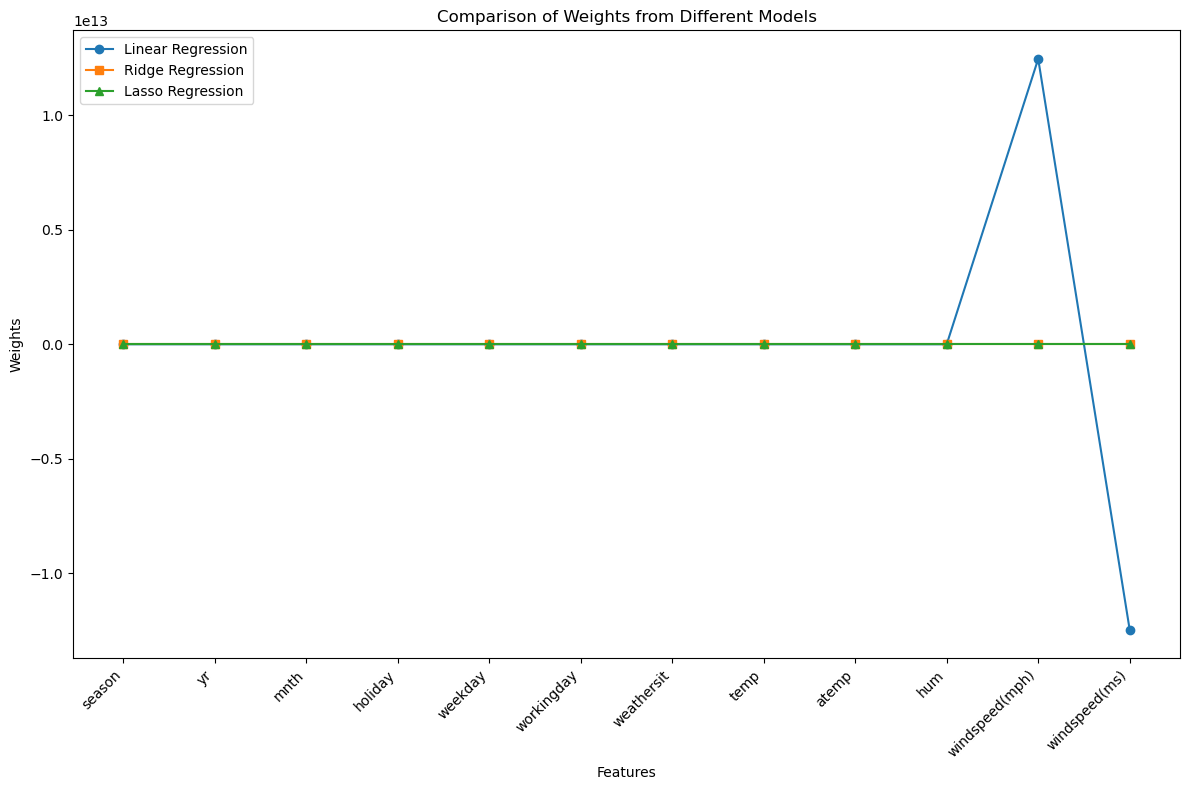

In [19]:

# Створюємо графік
plt.figure(figsize=(12, 8))

# Лінійні графіки для кожної моделі
plt.plot(df_weights['Feature'], df_weights['Linear Regression'], label='Linear Regression', marker='o')
plt.plot(df_weights['Feature'], df_weights['Ridge Regression'], label='Ridge Regression', marker='s')
plt.plot(df_weights['Feature'], df_weights['Lasso Regression'], label='Lasso Regression', marker='^')

# Налаштування графіка
plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('Comparison of Weights from Different Models')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Показуємо графік
plt.tight_layout()
plt.show()

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [20]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = linear_model.Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)
    print(f'{alpha = }, {coefs_lasso[-1][-1].round(6)=}')

    ridge_regressor = linear_model.Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)
    print(f'{alpha = }, {coefs_ridge[-1][-1].round(6)=}')
    print()

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print(f'{coefs_lasso.shape = }')
print(f'{coefs_ridge.shape = }')


alpha = np.int64(1), coefs_lasso[-1][-1].round(6)=np.float64(-0.0)
alpha = np.int64(1), coefs_ridge[-1][-1].round(6)=np.float64(-99.259441)

alpha = np.int64(51), coefs_lasso[-1][-1].round(6)=np.float64(-0.0)
alpha = np.int64(51), coefs_ridge[-1][-1].round(6)=np.float64(-101.627315)

alpha = np.int64(101), coefs_lasso[-1][-1].round(6)=np.float64(-0.0)
alpha = np.int64(101), coefs_ridge[-1][-1].round(6)=np.float64(-102.101671)

alpha = np.int64(151), coefs_lasso[-1][-1].round(6)=np.float64(-0.0)
alpha = np.int64(151), coefs_ridge[-1][-1].round(6)=np.float64(-102.005376)

alpha = np.int64(201), coefs_lasso[-1][-1].round(6)=np.float64(-0.0)
alpha = np.int64(201), coefs_ridge[-1][-1].round(6)=np.float64(-101.586385)

alpha = np.int64(251), coefs_lasso[-1][-1].round(6)=np.float64(-0.0)
alpha = np.int64(251), coefs_ridge[-1][-1].round(6)=np.float64(-100.964711)

alpha = np.int64(301), coefs_lasso[-1][-1].round(6)=np.float64(-0.0)
alpha = np.int64(301), coefs_ridge[-1][-1].round(6)=np.float64

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

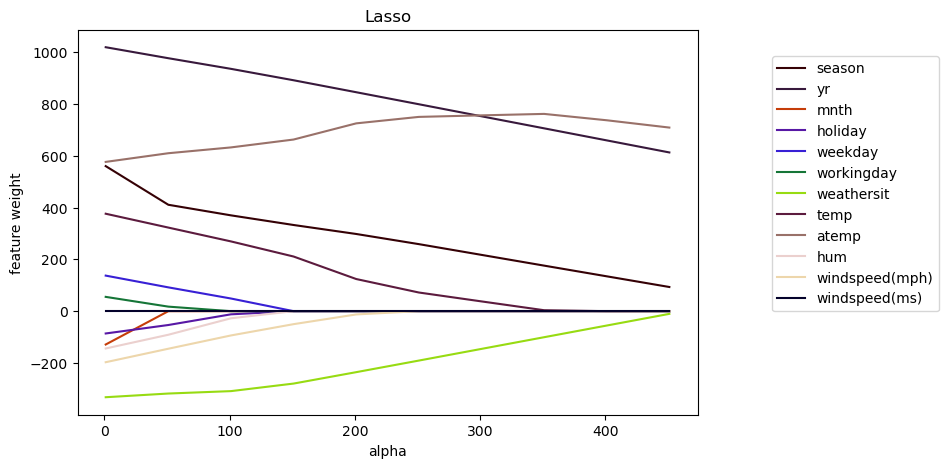

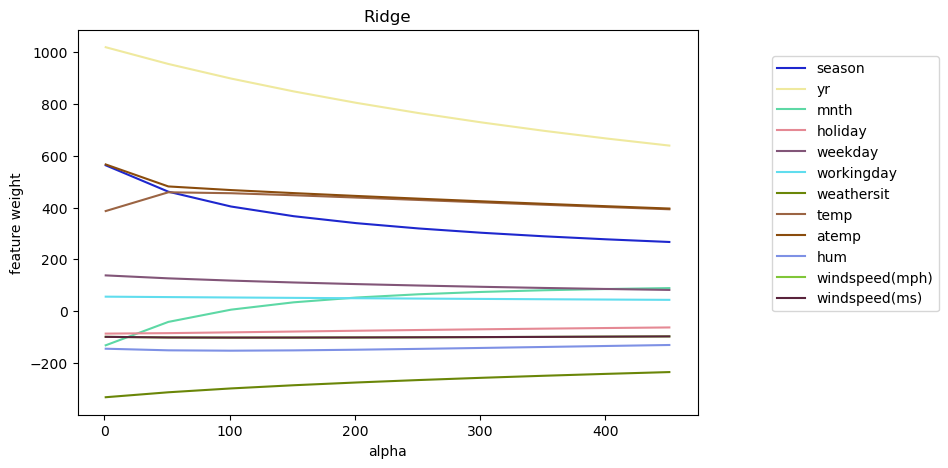

In [21]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

**Lasso** ефективний, якщо потрібно відібрати лише найважливіші змінні (він зануляє незначні коефіцієнти).

**Ridge** підходить для ситуацій, коли всі змінні важливі, але їх внесок потрібно згладити (усі коефіцієнти зменшуються, але залишаються ненульовими).

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

## 1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому α?

**Lasso (L1-регуляризація)** агресивніше зменшує ваги, оскільки воно може занулювати деякі коефіцієнти, роблячи їх рівними 0.  
**Ridge (L2-регуляризація)** натомість лише зменшує ваги, але ніколи не зануляє їх повністю.

### Причина цього — різна природа штрафних термів:

- **Lasso (L1)** використовує абсолютну суму ваг:    $  \sum |w_i|  $

  Це стимулює окремі ваги ставати рівними нулю, що може допомогти у відборі ознак.

- **Ridge (L2)** використовує квадрат ваг:  $  \sum w_i^2 $

  Це рівномірно зменшує всі ваги, але не виключає жодної змінної.

Таким чином, Lasso регресія є більш агресивною в сенсі занулення ваг і може бути корисною для усунення нерелевантних ознак у моделі.


## 2. Що станеться з вагами Lasso, якщо α зробити дуже великим?

Якщо **α → ∞**, то всі коефіцієнти в **Lasso** стануть **нульовими**.

### 🔹 Чому це відбувається?
При дуже великому **α**, вираз: $||y - Xw||^2 + \alpha ||w||_1$
мінімізується таким чином, щоб зменшити **L1-норму** коефіцієнтів $( ||w||_1 )$ настільки, наскільки можливо.

Оскільки:
$
||w||_1 = \sum |w_i|
$
є сумою абсолютних значень коефіцієнтів, найкращий спосіб зробити цей вираз малим — **занулити всі коефіцієнти**.

### 📌 Висновок:
Якщо зробити alpha занадто великим то всі ваги окрім bias стануть рівними нулю. Це відбувається через те, що функціонал втрат і регуляризаційний член стають практично рівними, і мінімізація функціоналу втрат вже майже не залежить від значень ознак, що призводить до їх обнулення.


## 3. Чи можна стверджувати, що Lasso виключає одну з ознак *windspeed* при будь-якому значенні α > 0?

Так, якщо **α > 0**, то **Lasso** може занулити вагу ознаки *windspeed*, але не обов’язково це зробить.

### 🔹 Чому?
- Якщо **α дуже мале**, регуляризація майже не впливає, і всі коефіцієнти можуть залишитися ненульовими.
- Якщо **α стає достатньо великим**, **Lasso** видалить слабші ознаки, зануляючи їх коефіцієнти.
- Якщо *windspeed* має **малий внесок у прогноз**, то його коефіцієнт швидко стане нулем.

### 🔹 А Ridge?
- **Ridge ніколи не занулює ознаки**, незалежно від значення **α**.
- Навіть при дуже великому **α** всі коефіцієнти просто стають дуже малими, але не рівними нулю.
- Тобто **Ridge не виключає ознаки, лише зменшує їхній вплив**.


## Який із регуляризаторів підійде для відбору неінформативних ознак?

**Lasso** краще підходить для відбору **неінформативних ознак**, оскільки воно може **занулювати коефіцієнти**, ефективно видаляючи **малозначущі змінні**.

### 🔹 Чому Lasso?
- **Lasso (L1-регуляризація)** додає штраф за суму абсолютних значень коефіцієнтів:$  ||y - Xw||^2 + \alpha ||w||_1$
- Це стимулює **деякі коефіцієнти ставати рівними 0**, що призводить до автоматичного **відбору найбільш значущих ознак**.

### 🔹 Чи підходить Ridge?
- **Ridge (L2-регуляризація)** додає штраф за суму квадратів коефіцієнтів:
 $  ||y - Xw||^2 + \alpha ||w||_2^2$
- Ridge **ніколи не занулює коефіцієнти**, а лише зменшує їхню величину.
- Це робить його **менш корисним для відбору ознак**, оскільки всі ознаки залишаються у моделі.

### 📌 Висновок:
Lasso є більш підходящим для відбiру неінформативних ознак, оскільки вона схильна обнулювати ваги для ознак.
Якщо мета — **автоматичний відбір ознак** (*Feature Selection*), **Lasso є гарним вибором**. Ridge, натомість, підходить більше для **зменшення мультиколінеарності**, але не для видалення ознак.


### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [22]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

regressor.alphas_ = array([96, 91, 86, 81, 76, 71, 66, 61, 56, 51, 46, 41, 36, 31, 26, 21, 16,
       11,  6,  1])
regressor.coef_.shape = (12,)
regressor.alphas_.shape = (20,)
regressor.mse_path_.shape = (20, 3)


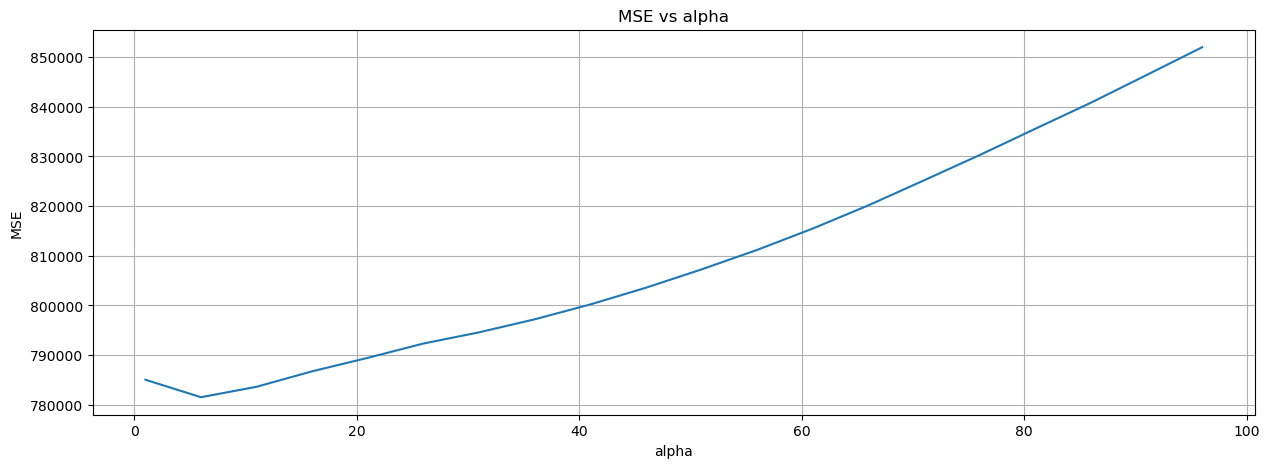

In [23]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(random_state=SEED, alphas=alphas, cv=3)
regressor.fit(X, y)

# print(f'{regressor.coef_.round(3) = }')
# print(f'{regressor.intercept_ = }')
# print(f'{regressor.mse_path_ = }')
print(f'{regressor.alphas_ = }')

print(f'{regressor.coef_.shape = }')
print(f'{regressor.alphas_.shape = }')
print(f'{regressor.mse_path_.shape = }')

mse_values = np.mean(regressor.mse_path_, axis=1)
# mse_values = [i.mean() for i in regressor.mse_path_]
# print(f'{mse_values = }')

data = np.vstack((regressor.alphas_, mse_values)).T
# print(f'{data = }')
# data = list(zip(regressor.alphas_, mse_values))
# print(f'{data = }')

create_plot(data, 'MSE vs alpha', 'alpha', 'MSE')

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Оптимальні alpha для мінімального MSE у кожному розбитті: [ 6  1 51]


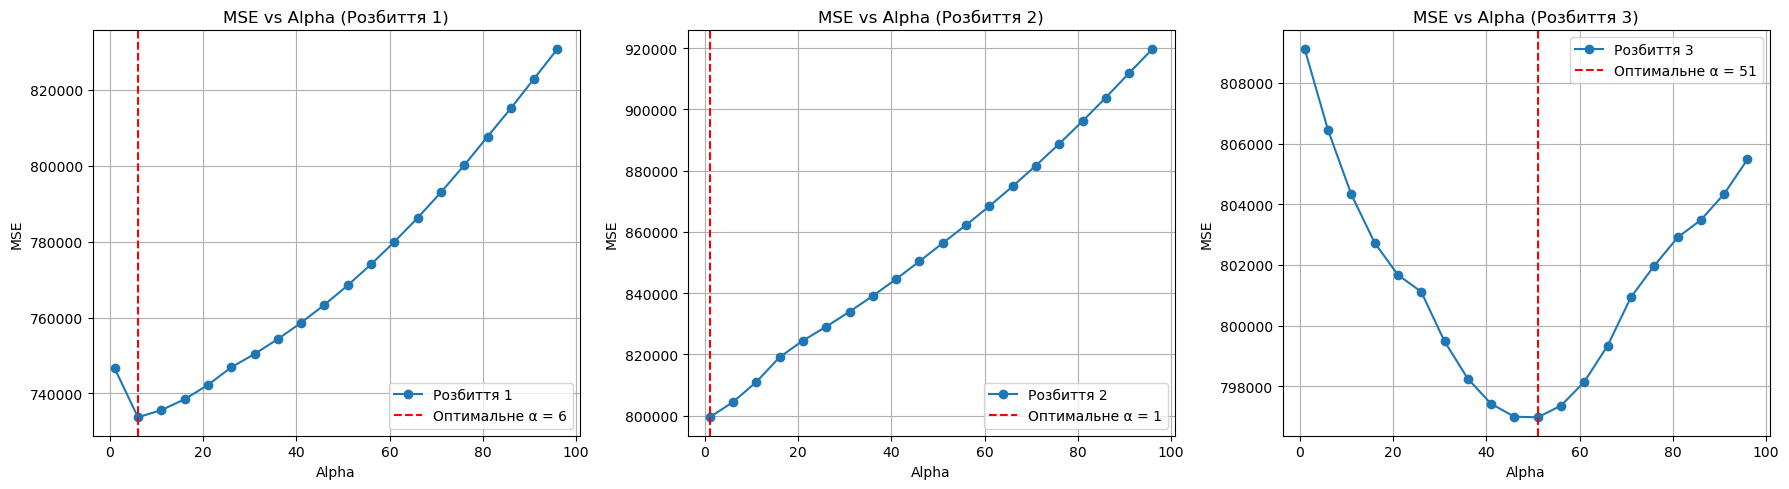

In [24]:
def plot_mse_vs_alpha(ax, alphas, mse_values, best_alpha, split_index):
    ax.plot(alphas, mse_values, marker='o', label=f'Розбиття {split_index+1}')
    # print(type(best_alpha), best_alpha)
    ax.axvline(best_alpha, color='r', linestyle='--', label=f'Оптимальне α = {best_alpha}')  #  vertical line
    ax.set_title(f'MSE vs Alpha (Розбиття {split_index+1})')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('MSE')
    ax.grid()
    ax.legend()

# Знаходження індексів мінімальних значень MSE у кожному стовпці
min_indices = np.argmin(regressor.mse_path_, axis=0)  # Індекси мінімальних значень
best_alphas = regressor.alphas_[min_indices]  # Відповідні alpha

min_alphas = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]
min_mses = np.min(regressor.mse_path_, axis=0)

print(f'Оптимальні alpha для мінімального MSE у кожному розбитті: {best_alphas}')

# Побудова графіків
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    plot_mse_vs_alpha(axes[i], regressor.alphas_, regressor.mse_path_[:, i], best_alphas[i], i)

plt.tight_layout()
plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

На графіках видно лінійну залежність. З підвищенням значень цих ознак зростає кількість орендованих велосипедів.

Ось 4 ознаки з найбільшими позитивними коефіцієнтами:

In [25]:
max_4_features = sorted([i for i in list(zip(df.columns, regressor.coef_))], key=lambda x: x[1], reverse=True)[:4]
max_4_features

[('yr', np.float64(1015.0602226430597)),
 ('atemp', np.float64(581.3969310654987)),
 ('season', np.float64(532.0189828413537)),
 ('temp', np.float64(370.6798550300334))]

In [26]:
data_coef = pd.DataFrame(regressor.coef_,index=df.columns[:-1], columns=["Weight"])
# data_coef

In [27]:
data_coef[data_coef > 0].dropna().sort_values(by=['Weight'],ascending=False).head(4)

,Weight
yr,1015.060223
atemp,581.396931
season,532.018983
temp,370.679855


З цього результату видно, що ознаки з найбільшими коефіцієнтами — це 'yr' (рік), 'atemp' (температура, що відчувається), 'season' (сезон) і 'temp' (температура повітря), що означає, що з підвищенням цих значень можна очікувати збільшення кількості орендованих велосипедів.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [28]:
# min_3_features = sorted([i for i in list(zip(df.columns, regressor.coef_))], key=lambda x: x[1], reverse=True)[-3:]
min_3_features = sorted([i for i in list(zip(df.columns, regressor.coef_))], key=lambda x: x[1])[:3]
min_3_features

[('weathersit', np.float64(-330.5598567399813)),
 ('windspeed(mph)', np.float64(-191.77140847134925)),
 ('hum', np.float64(-140.00740550068866))]

In [29]:
data_coef[data_coef < 0].dropna().abs().sort_values(by=['Weight'],ascending=False).head(3)

,Weight
weathersit,330.559857
windspeed(mph),191.771408
hum,140.007406


Ці ознаки мають негативний вплив на кількість орендованих велосипедів. З підвищенням значень цих ознак можна очікувати зменшення кількості орендованих велосипедів.

На візуалізаціях повинна бути видно зменшувану лінійну залежність: з ростом значень вологість, швидкість вітру та складність погоди кількість орендованих велосипедів зменшується.

Тому можна логічно стверджувати, що з підвищенням значень цих ознак, ймовірно, зменшиться кількість людей, які захочуть взяти велосипеди.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [30]:
min_3_features = list(filter(lambda x:  -(1e-3) < x[1] < (1e-3), [i for i in list(zip(df.columns, regressor.coef_))]))
min_3_features

[('windspeed(ms)', np.float64(-2.6855907924014633e-08))]

In [31]:
data_coef[data_coef.abs() < 1e-03].dropna()

,Weight
windspeed(ms),-2.685591e-08


Ознака 'windspeed(ms)' має коефіцієнт, близький до нуля (-2.685470e-08), що вказує на дуже слабкий або відсутній лінійний зв'язок з кількістю орендованих велосипедів. Така ознака може бути виключена моделлю через те, що її вплив на результат є надто малим.

Ці ознаки мають дуже незначний вплив на попит на велосипеди. Однак ми не можемо сказати, що вони зовсім не впливають, але їх вплив дуже слабкий і в межах статистичної похибки.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.